In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import re
import sys
import os
import mne
import mne_connectivity
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 
import itertools
from plotnine import *
import pickle
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
import tensorpac as tp

In [2]:
## Prep paths ##

subject = 'BJH027'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [4]:
## Load Neural Data

# load
last_away_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_filtered_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if  x]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

# set info as metadata
last_away_epochs.metadata = last_away_data

# onlt good epochs
last_away_epochs = last_away_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events.fif ...


/tmp/ipykernel_225604/1489456339.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events-1.fif ...
    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
207 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns


In [5]:
last_away_epochs = last_away_epochs.resample(512)

In [ ]:
last_away_epochs = last_away_epochs.crop(tmin=-2, tmax=0)

In [6]:
ofc_data = last_away_epochs.copy().pick(['AL10-AL11'])
amyg_data = last_away_epochs.copy().pick(['GL4-GL5'])

In [7]:
ofc_array = ofc_data.get_data()
amyg_array = amyg_data.get_data()

/tmp/ipykernel_225604/3151387714.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
/tmp/ipykernel_225604/3151387714.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


In [8]:
ofc_array = np.squeeze(ofc_array)
ofc_array.shape

(140, 5120)

In [9]:
amyg_array = np.squeeze(amyg_array)
amyg_array.shape

(140, 5120)

In [11]:
# Define a Pac object
p = tp.Pac(idpac=(6, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
# ofc_to_amyg = p.filterfit(last_away_epochs.info['sfreq'], ofc_array, amyg_array)
# amyg_to_ofc= p.filterfit(last_away_epochs.info['sfreq'], amyg_array, ofc_array)

Phase Amplitude Coupling object defined


In [18]:
plt.rcParams['figure.figsize'] = [15, 10]

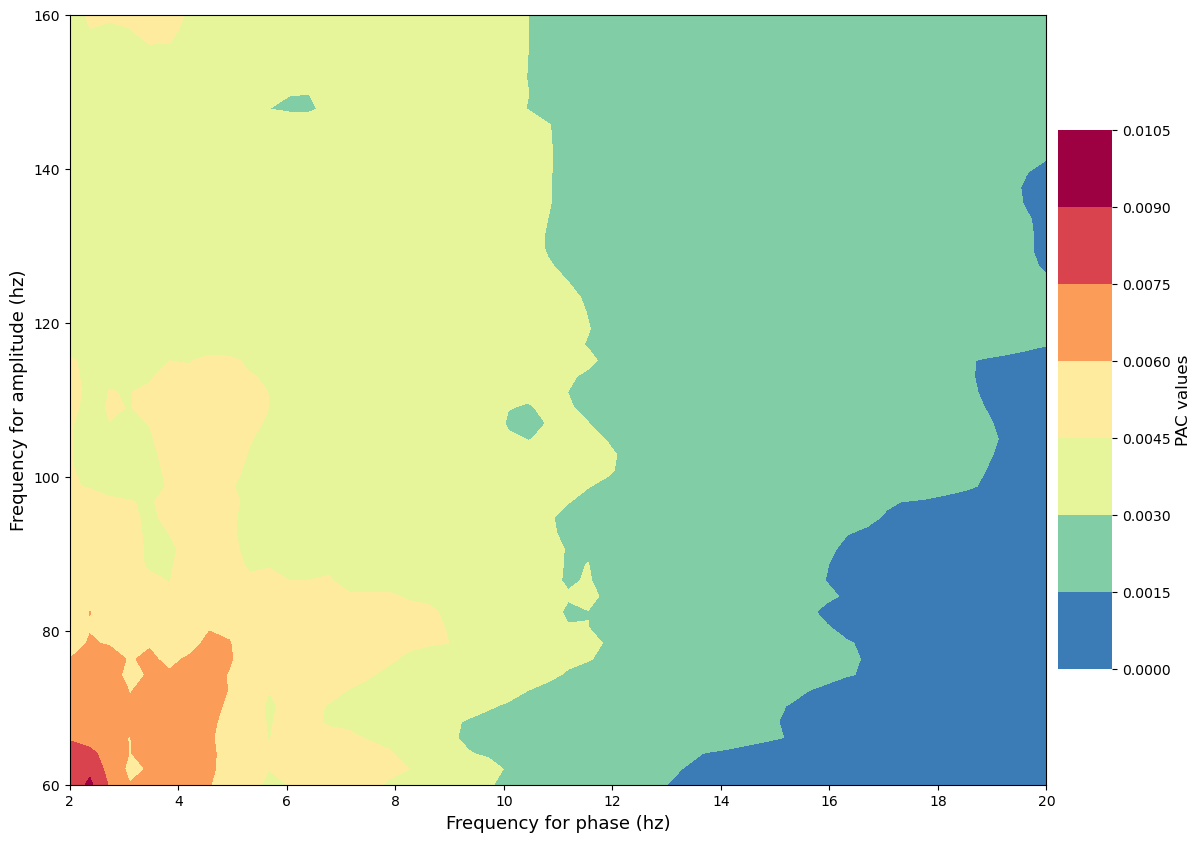

In [19]:
# plot your Phase-Amplitude Coupling :
p.comodulogram(ofc_to_amyg.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title='',
               fz_title=14, fz_labels=13)

p.show()

In [20]:
# plot your Phase-Amplitude Coupling :
p.comodulogram(amyg_to_ofc.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title='',
               fz_title=14, fz_labels=13)

p.show()

In [68]:
p_tmp = tp.Pac(idpac=(2, 0, 0), f_pha='hres', f_amp='hres')
theta_phases = [x for x in p_tmp.f_pha if x[0] >= 2 and x[1] <= 9]
hfa_amps = [x for x in p_tmp.f_amp if x[0] >= 70]

Phase Amplitude Coupling object defined


In [69]:
# Now, extract all of the phases and amplitudes
p = tp.Pac(idpac=(2, 0, 0), f_pha=theta_phases, f_amp=hfa_amps)
phases = p.filter(last_away_epochs.info['sfreq'], amyg_array, ftype='phase', n_jobs = 16)
amplitudes = p.filter(last_away_epochs.info['sfreq'], ofc_array, ftype='amplitude', n_jobs = 16)
p.idpac = (2, 3, 4)
xpac = p.fit(phases, amplitudes, n_perm=200, n_jobs = 16, mcp = 'fdr')

Phase Amplitude Coupling object defined
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)
    compute surrogates (Time lag (Canolty et al. 2006), 200 permutations, random_state=3796)
    infer p-values at (p=0.05, mcp=fdr)
    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)


<Axes: title={'center': 'Time lag\n(Canolty et al. 2006)'}, xlabel='Frequency for phase (hz)', ylabel='Frequency for amplitude (hz)'>

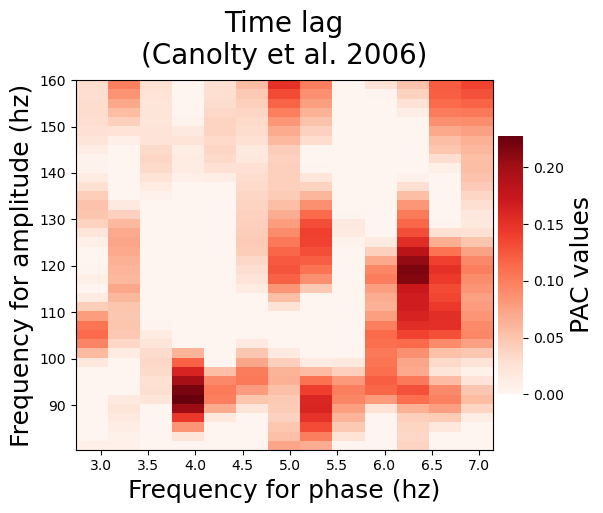

In [70]:
title = p.str_surro.replace(' (', '\n(')
p.comodulogram(xpac.mean(-1), title=title, cmap='Reds', vmin=0,
                fz_labels=18, fz_title=20, fz_cblabel=18)

In [67]:
# Save the object to a file
with open('tmp_pac.pkl', 'wb') as file:
    pickle.dump(p, file)

In [71]:
tmp = p.pvalues == 1
np.unique(tmp, return_counts = True)

(array([ True]), array([520]))

In [72]:
mcp = 'fdr'
pvalues = p.infer_pvalues(p=.05, mcp=mcp)
np.unique(pvalues, return_counts = True)

    infer p-values at (p=0.05, mcp=fdr)


(array([1.]), array([520]))

In [63]:
# plot the non-significant pac in gray
pac_prep_ns = xpac.mean(-1).copy()
pac_prep_ns[pvalues < .05] = np.nan
p.comodulogram(pac_prep_ns, cmap='grey', vmin=np.nanmin(pac_prep_ns),
                   vmax=np.nanmax(pac_prep_ns), colorbar=False)
# plot the significant pac in color
pac_prep_s = xpac.mean(-1).copy()
pac_prep_s[pvalues >= .05] = np.nan
p.comodulogram(pac_prep_s, cmap='Spectral_r', vmin=np.nanmin(pac_prep_s),
                   vmax=np.nanmax(pac_prep_s), title=title)
plt.gca().invert_yaxis()
plt.show()

/tmp/ipykernel_142803/550690198.py:9: RuntimeWarning: All-NaN slice encountered
/tmp/ipykernel_142803/550690198.py:10: RuntimeWarning: All-NaN slice encountered


In [14]:
# Now, extract all of the phases and amplitudes
p = tp.Pac(idpac=(6, 0, 0), f_pha='hres', f_amp='hres')
phases = p.filter(last_away_epochs.info['sfreq'], amyg_array, ftype='phase', n_jobs = 16)
amplitudes = p.filter(last_away_epochs.info['sfreq'], ofc_array, ftype='amplitude', n_jobs = 16)

Phase Amplitude Coupling object defined


In [15]:
plt.figure(figsize=(16, 12))
for i, k in enumerate([0, 1, 2, 3]):
    # change the pac method
    p.idpac = (6, k, 4)
    # compute only the pac without filtering
    xpac = p.fit(phases, amplitudes, n_perm=20, n_jobs = 16)
    # plot
    title = p.str_surro.replace(' (', '\n(')
    plt.subplot(2, 2, k + 1)
    p.comodulogram(xpac.mean(-1), title=title, cmap='Reds', vmin=0,
                   fz_labels=18, fz_title=20, fz_cblabel=18)

plt.tight_layout()

plt.show()

WARNING | If you want to normalize the estimated PAC, you should select a surrogate method (second digit of `idpac`). Normalization ignored.
    true PAC estimation using Gaussian Copula PAC (gcPac)
    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Permute phase across trials (Tort et al. 2010), 20 permutations, random_state=7232)
WARNING | For inferences at p<0.05, it is recommended to perform at least n_perm=200 permutations
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 20 permutations, random_state=4653)
WARNING | For inferences at p<0.05, it is recommended to perform at least n_perm=200 permutations
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the

    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Time lag (Canolty et al. 2006), 200 permutations, random_state=8967)
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)


<Axes: title={'center': 'Time lag\n(Canolty et al. 2006)'}, xlabel='Frequency for phase (hz)', ylabel='Frequency for amplitude (hz)'>

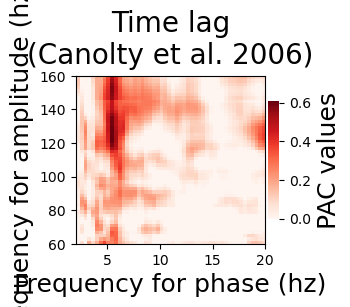

In [20]:
xpac = p.fit(phases, amplitudes, n_perm=200, n_jobs = 16)
# plot
title = p.str_surro.replace(' (', '\n(')
plt.subplot(2, 2, k + 1)
p.comodulogram(xpac.mean(-1), title=title, cmap='Reds', vmin=0,
                fz_labels=18, fz_title=20, fz_cblabel=18)

In [24]:
## drops to .6 with full shuffled distribution, still nothing significant
plt.figure(figsize=(8, 6))
p.comodulogram(xpac.mean(-1), title=title, cmap='Reds', vmin=0,
                fz_labels=18, fz_title=20, fz_cblabel=18)

<Axes: title={'center': 'Time lag\n(Canolty et al. 2006)'}, xlabel='Frequency for phase (hz)', ylabel='Frequency for amplitude (hz)'>

In [27]:
## drops to .6 with full shuffled distribution, still nothing significant
plt.figure(figsize=(8, 6))
p.idpac = (1, 0, 0)
# compute only the pac without filtering
xpac = p.fit(phases, amplitudes, n_perm=0, n_jobs = 16)
p.comodulogram(p.pac.mean(-1), title=title, cmap='Reds', vmin=0,
                fz_labels=18, fz_title=20, fz_cblabel=18)

WARNING | MVL is amplitude dependent which means that if the amplitude increases, MVL also increases. You should select a normalization method for correcting this limitation (e.g idpac=(1, 2, 4))
    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)


<Axes: title={'center': 'Time lag\n(Canolty et al. 2006)'}, xlabel='Frequency for phase (hz)', ylabel='Frequency for amplitude (hz)'>

In [25]:
print(np.unique(p.pvalues, return_counts = True))

(array([1.]), array([2500]))


In [ ]:
print(np.unique(p.pvalues, return_counts = True))

(array([1.]), array([2500]))


<Axes: title={'center': 'Time lag\n(Canolty et al. 2006)'}, xlabel='Frequency for phase (hz)', ylabel='Frequency for amplitude (hz)'>

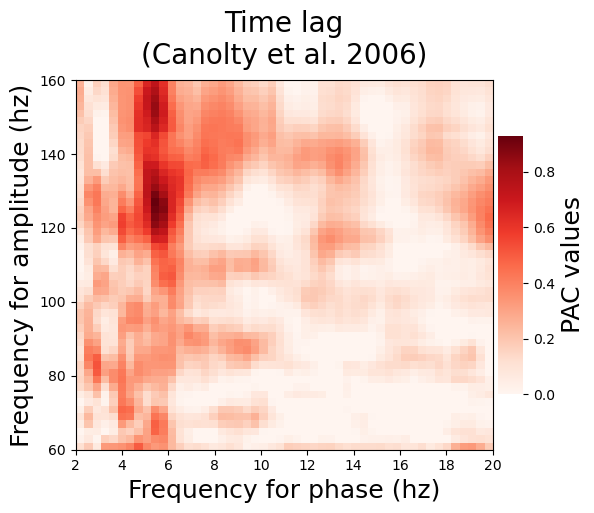

In [17]:
## it is not the manual std
xpac = (p.pac - p.surrogates.mean(axis = 0)) / np.std(p.surrogates, axis = 0)
p.comodulogram(xpac.mean(-1), title=title, cmap='Reds', vmin=0,
                   fz_labels=18, fz_title=20, fz_cblabel=18)

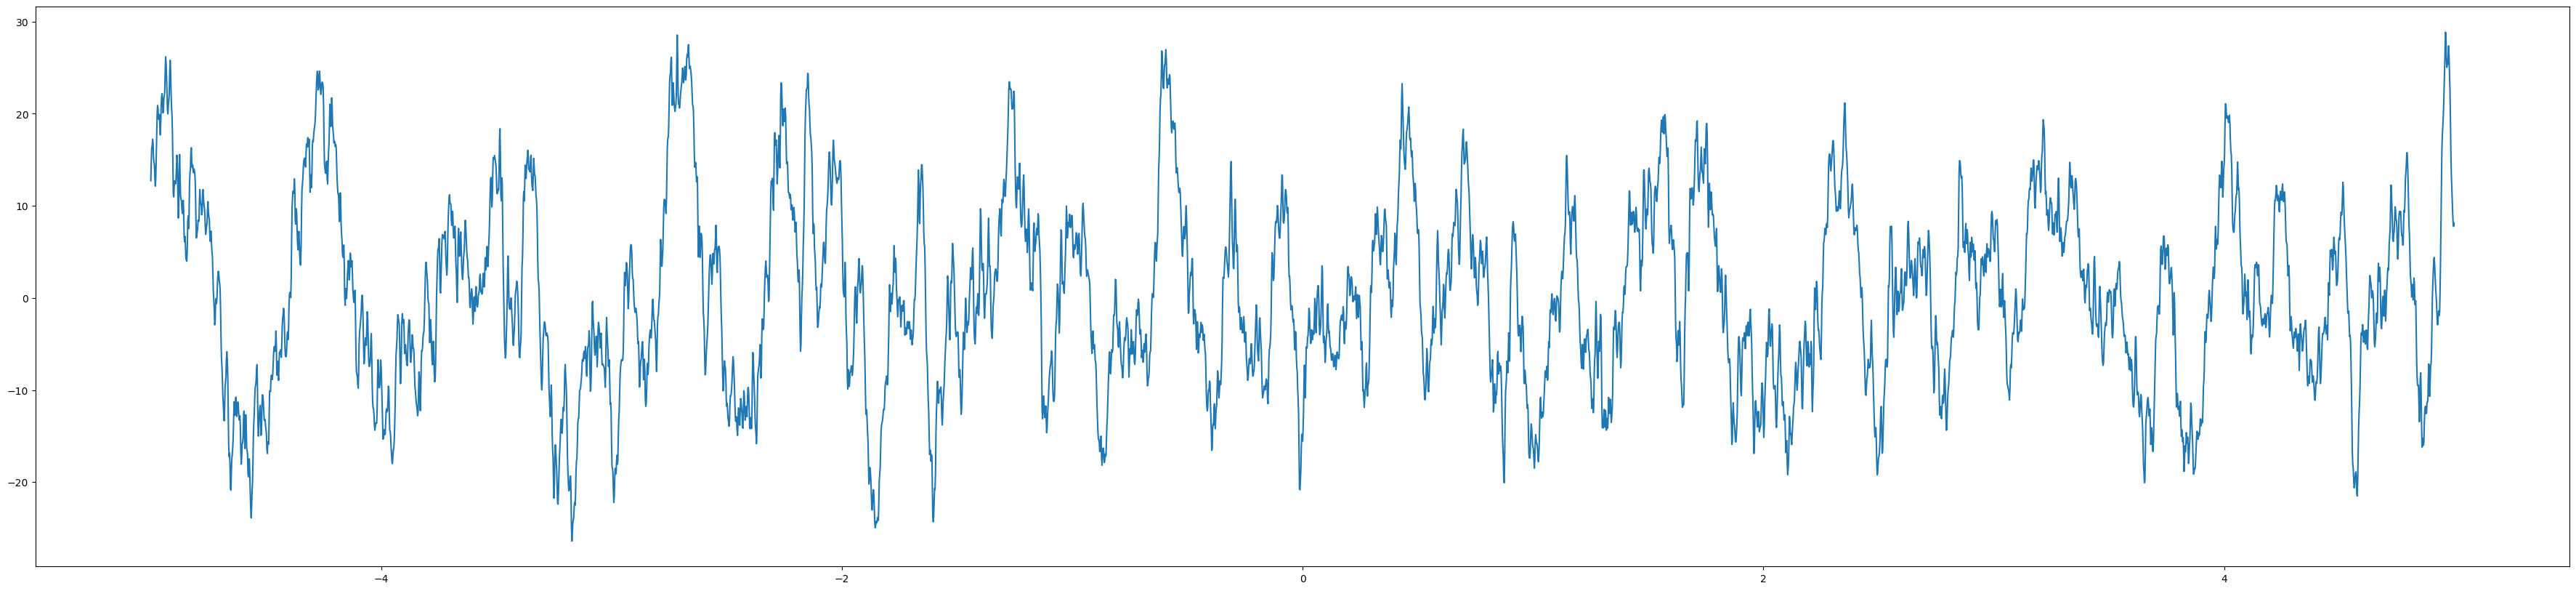

In [21]:
plt.rcParams['figure.figsize'] = [45, 10]


plt.plot(last_away_epochs.times, amyg_array[0,:])

In [22]:
plt.rcParams['figure.figsize'] = [15, 10]

time_index = np.where((last_away_epochs.times <= -1) & (last_away_epochs.times >= -2))
time_series = np.squeeze(amyg_array[0,time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

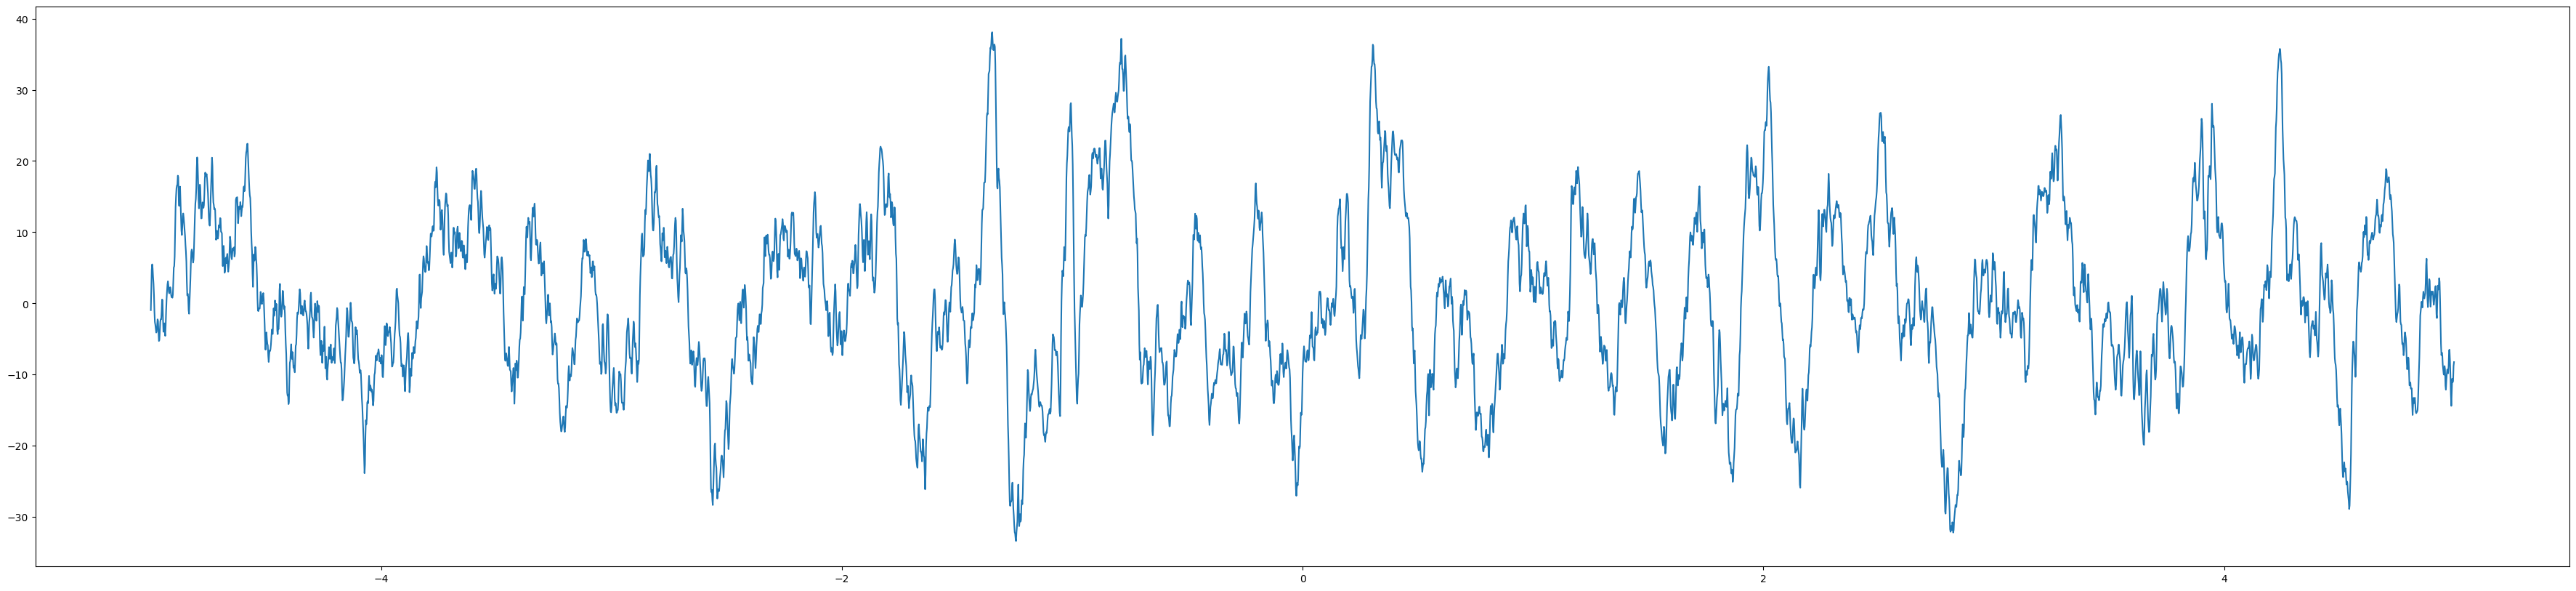

In [23]:
plt.rcParams['figure.figsize'] = [45, 10]


plt.plot(last_away_epochs.times, amyg_array[99,:])

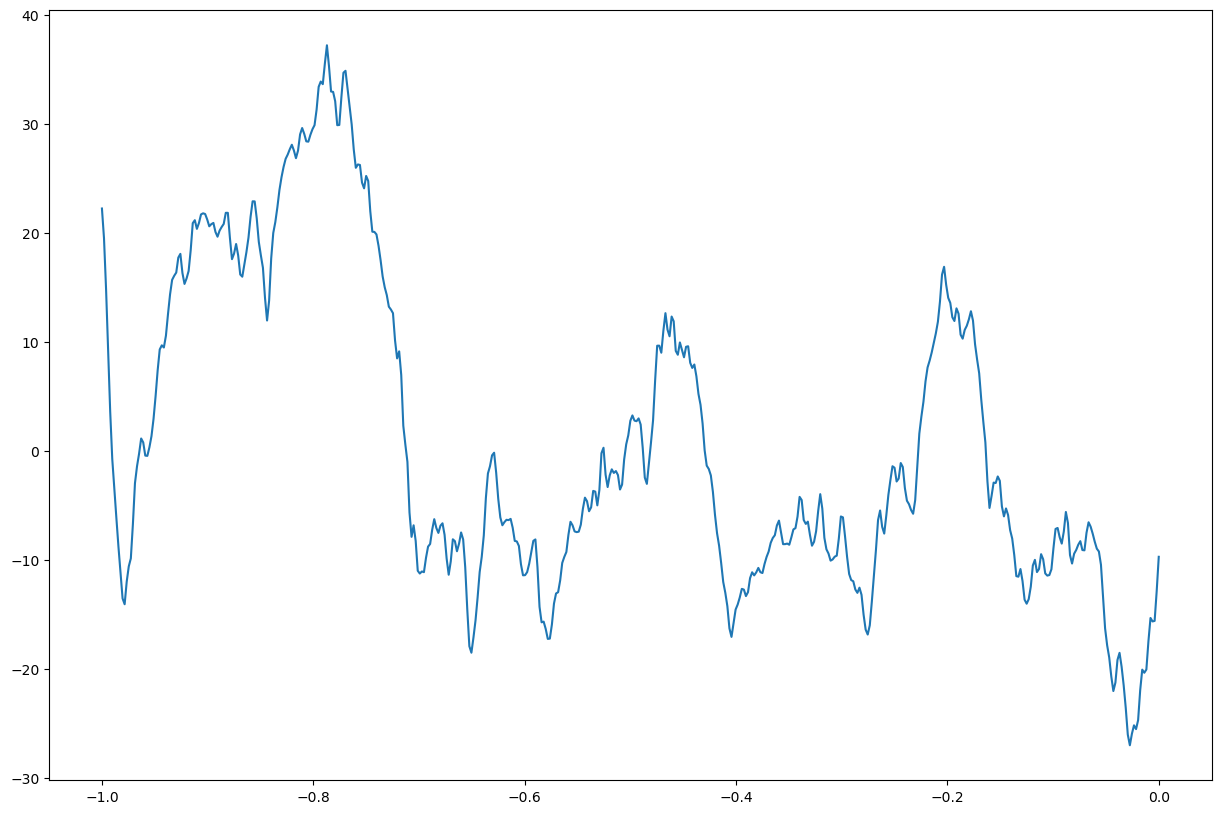

In [24]:
plt.rcParams['figure.figsize'] = [15, 10]

time_index = np.where((last_away_epochs.times <= 0) & (last_away_epochs.times >= -1))
time_series = np.squeeze(amyg_array[99,time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

In [25]:
itc = tp.utils.ITC(amyg_array, last_away_epochs.info['sfreq'], f_pha=(2, 20, 1, .2))


Inter-Trials Coherence (ITC)
    extracting 85 phases


In [26]:
itc.plot(times=last_away_epochs.times, cmap='plasma', fz_labels=15, fz_title=18)

<Axes: title={'center': 'Inter-Trials Coherence (140 trials)'}, xlabel='Time', ylabel='Frequency for phase (Hz)'>

In [27]:
psd = tp.utils.PSD(amyg_array, last_away_epochs.info['sfreq'])


Compute PSD over 140 trials and 5120 time points


    Add 95th confidence interval
/tmp/ipykernel_72973/2617122386.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


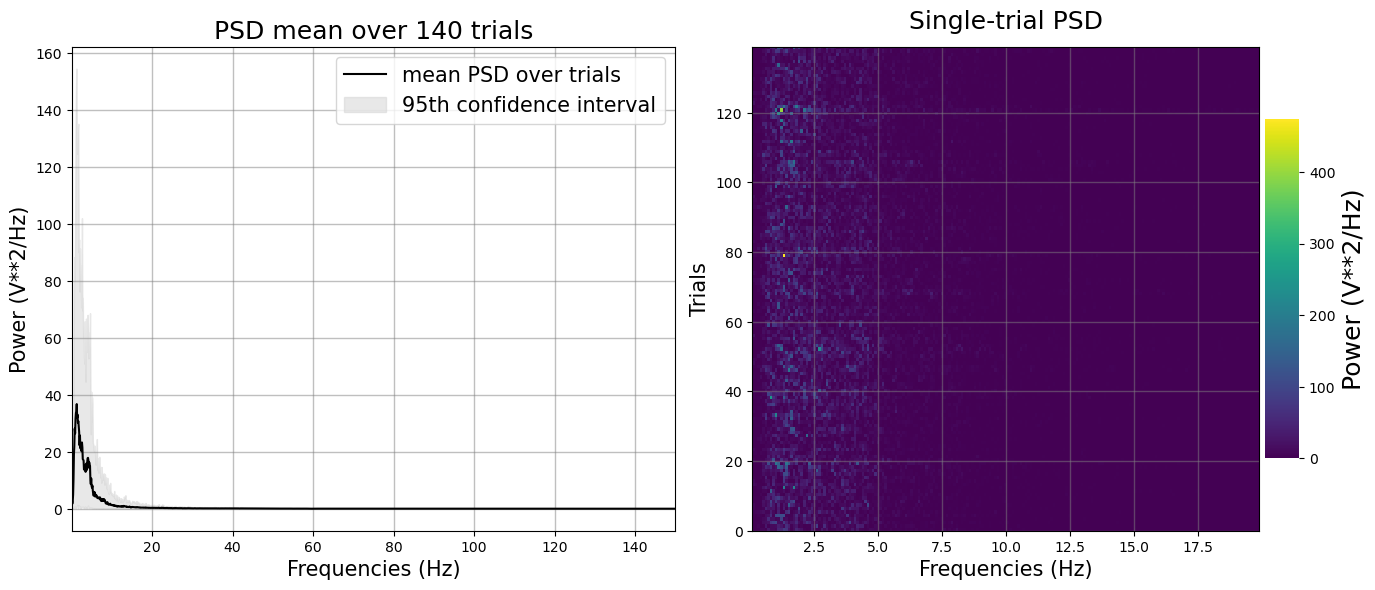

In [28]:
plt.figure(figsize=(14, 6))
# adding the mean PSD over trials
plt.subplot(1, 2, 1)
ax = psd.plot(confidence=95, f_min=0.1, f_max=150, grid=True)
# plt.axvline(8, lw=2, color='red')
# plt.axvline(12, lw=2, color='red')
# adding the single trial PSD
plt.subplot(1, 2, 2)
psd.plot_st_psd( f_min=.1, f_max=20, 
                grid=True)
# plt.axvline(8, lw=2, color='red')
# plt.axvline(12, lw=2, color='red')
plt.tight_layout()
plt.show()

    Add 95th confidence interval
/tmp/ipykernel_72973/967805332.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


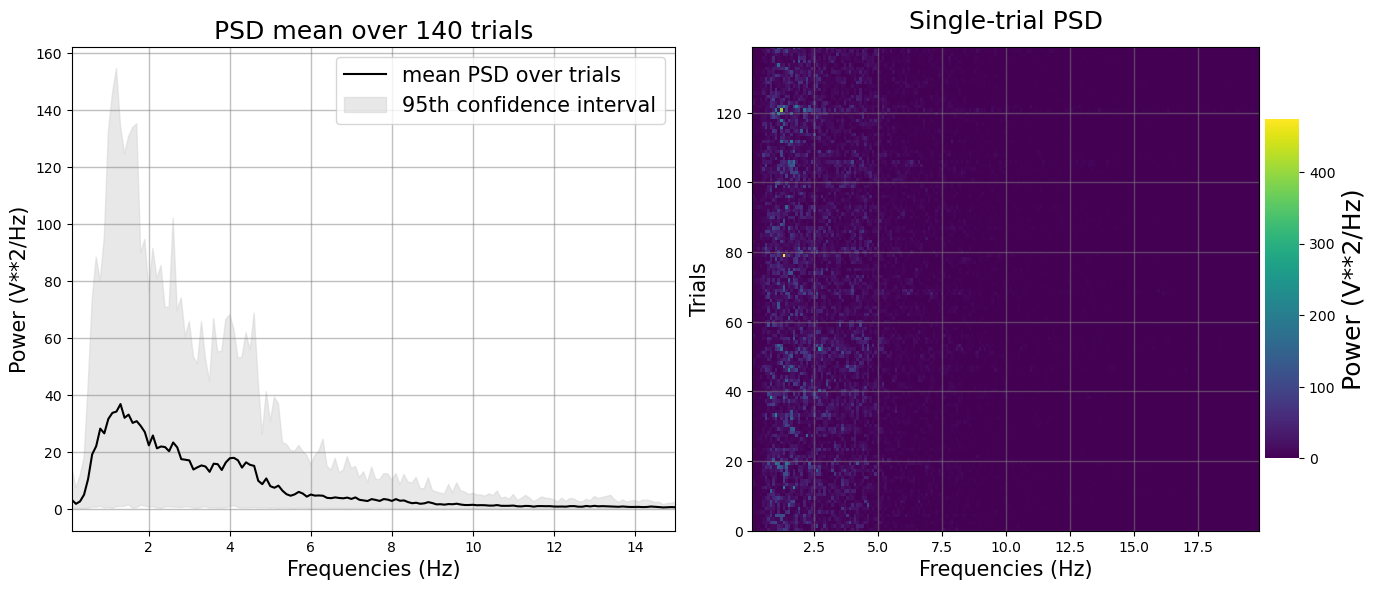

In [29]:
plt.figure(figsize=(14, 6))
# adding the mean PSD over trials
plt.subplot(1, 2, 1)
ax = psd.plot(confidence=95, f_min=0.1, f_max=15, grid=True)
# plt.axvline(8, lw=2, color='red')
# plt.axvline(12, lw=2, color='red')
# adding the single trial PSD
plt.subplot(1, 2, 2)
psd.plot_st_psd( f_min=.1, f_max=20, 
                grid=True)
# plt.axvline(8, lw=2, color='red')
# plt.axvline(12, lw=2, color='red')
plt.tight_layout()
plt.show()

In [9]:
rp_obj =tp.EventRelatedPac(f_pha=[3, 8], f_amp=(30, 160, 30, 2))
erpac = rp_obj.filterfit(example_channel.info['sfreq'], example_data, method='gc', smooth=100)


Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=50)
    Compute Gaussian-Copula ERPAC


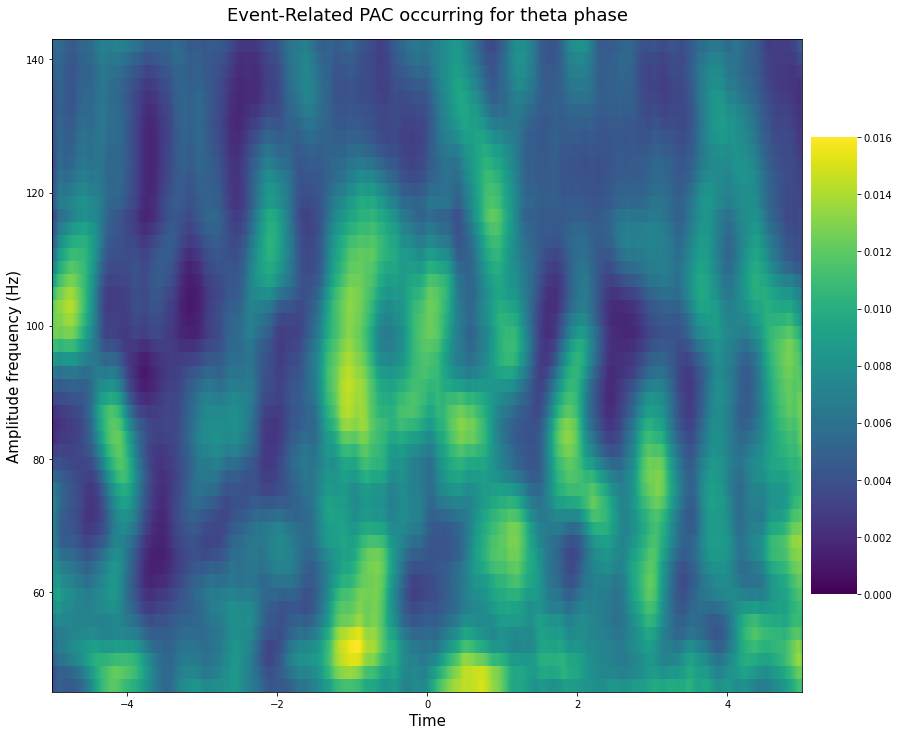

In [10]:
plt.figure(figsize=(16, 12))
rp_obj.pacplot(erpac.squeeze(), last_away_epochs.times, rp_obj.yvec, xlabel='Time',
               ylabel='Amplitude frequency (Hz)',
               title='Event-Related PAC occurring for theta phase',
               fz_labels=15, fz_title=18)
plt.show()

In [98]:
example_data.shape

(140, 5120)

In [172]:
peak = tp.utils.PeakLockedTF(example_data, example_channel.info['sfreq'], 0., times=last_away_epochs.times, f_pha=[3, 6],
                    f_amp= 'hres')

PeakLockedTF object defined
    align on time-point=0.0 (sample=2559)
    extract phase and amplitudes (n_amps=50)
    running peak detection around sample=2559
    realign the 140 phases and amplitudes


In [218]:
peak

In [216]:
plt.figure(figsize=(16, 16))
ax_1, ax_2 = peak.plot(zscore=True, edges = 512, cmap='Spectral_r')
plt.tight_layout()
plt.show()

In [158]:
# define phase and amplitude filtering properties
kw_filt = dict(f_pha=[3, 6], f_amp=[60, 90], n_bins=20)
# bin the rest, planning and execution periods. Note that ideally, the entire
# trial should be filtered and then binning should be performed
bin_data = tp.utils.BinAmplitude(example_data, example_channel.info['sfreq'], **kw_filt)

Binning [60, 90]Hz amplitude according to [3, 6]Hz phase


In [159]:
plt.figure(figsize=(6, 5))
bin_data.plot(normalize=True,  unit='deg')
plt.ylim(0.7, 1.1), plt.title("", fontsize=18)


((0.7, 1.1), Text(0.5, 1.0, ''))

In [175]:
pp_obj = tp.PreferredPhase(f_pha=[3, 6])
# only extract the alpha phase
pp_pha = pp_obj.filter(example_channel.info['sfreq'], example_data, ftype='phase')
pp_amp = p.filter(example_channel.info['sfreq'], example_data, ftype='amplitude')
# compute the preferred phase (reuse the amplitude computed above)
ampbin, pp, vecbin = pp_obj.fit(pp_pha, pp_amp, n_bins=72)
# mean binned amplitude across trials
ampbin = np.squeeze(ampbin).mean(-1).T


Preferred phase object defined


(array([ 9., 11.,  8., 12., 12.,  9.,  5.,  3.,  6.,  3.,  2.,  1.,  1.,
         1.,  1.,  2.,  5.,  2.,  2.,  5.,  7.,  5.,  9.,  9., 10.]),
 array([-3.09795942, -2.85012267, -2.60228591, -2.35444916, -2.10661241,
        -1.85877565, -1.6109389 , -1.36310215, -1.11526539, -0.86742864,
        -0.61959188, -0.37175513, -0.12391838,  0.12391838,  0.37175513,
         0.61959188,  0.86742864,  1.11526539,  1.36310215,  1.6109389 ,
         1.85877565,  2.10661241,  2.35444916,  2.60228591,  2.85012267,
         3.09795942]),
 <BarContainer object of 25 artists>)

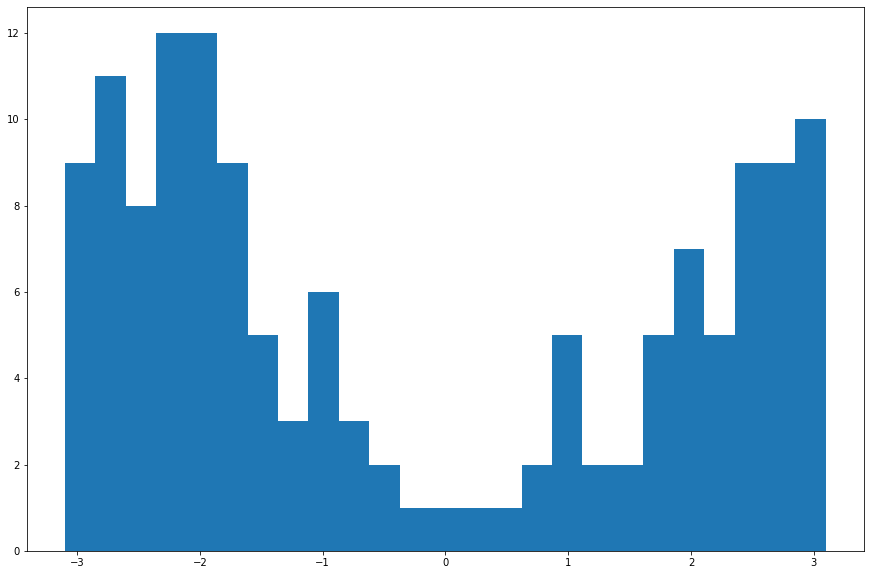

In [214]:
plt.hist(pp[14, 0, :], bins = 25)

In [178]:
pp_mean = np.squeeze(pp.mean(-1))

In [212]:
pp_mean[8:15]

array([-0.17889625, -0.23624278, -0.12528971, -0.09536978, -0.18949289,
       -0.33722254, -0.28860266])

In [163]:
plt.figure(figsize=(30, 8))
kw_plt = dict(cmap='Spectral_r', interp=.1, cblabel='Amplitude bins',
              vmin=0.013, vmax=0.015, colorbar=True, y=1.05, fz_title=18)
pp_obj.polar(ampbin, vecbin, p.yvec, subplot=131, title='',
             **kw_plt)


<PolarAxes: >

In [206]:
vecbin[5]

-2.6991148150560194

In [198]:
len(p.yvec)


50

In [201]:
pp_mean[0] # preferred phase for an amplitude bin of 60Hz

-0.22626947088355384

In [204]:
np.where(ampbin[0] == np.max(ampbin[0]))

(array([5]),)

In [205]:
ampbin[0]

array([0.01473017, 0.01473831, 0.01478396, 0.01481305, 0.01478002,
       0.01484038, 0.01479048, 0.01478654, 0.01474649, 0.0147374 ,
       0.01469205, 0.01457967, 0.01456308, 0.01453002, 0.01452111,
       0.01437493, 0.01442783, 0.01423311, 0.01415069, 0.01422825,
       0.0140848 , 0.01407516, 0.01393593, 0.01391273, 0.0138369 ,
       0.01372992, 0.01368391, 0.01355169, 0.01356146, 0.01344557,
       0.0134956 , 0.01337561, 0.01336956, 0.01336233, 0.0132774 ,
       0.01318631, 0.01327065, 0.01313595, 0.01313351, 0.01303898,
       0.01302286, 0.01303774, 0.0130071 , 0.01296007, 0.01299066,
       0.01304368, 0.01302287, 0.013108  , 0.01301415, 0.01313419,
       0.01314122, 0.0132714 , 0.0132036 , 0.01326137, 0.01327953,
       0.01346842, 0.01366999, 0.01373539, 0.01379421, 0.01386499,
       0.01393517, 0.01406727, 0.01413238, 0.01429884, 0.01419493,
       0.01438037, 0.01448366, 0.01450522, 0.01455874, 0.01459952,
       0.01463011, 0.01467084])

In [164]:
df = tp.stats.test_stationarity(example_data, p=0.05)
print(df)

Performing a Augmented Dickey-Fuller test on 140 epochs with p=0.05
    140/140 epochs were found as significantly stationary at p=0.05


        Epochs      P-values  Stationary  Statistics   CV (5%)   CV (1%)
0      epoch 0  2.278893e-22        True  -12.076919 -2.862108 -3.431636
1      epoch 1  2.060501e-20        True  -11.216755 -2.862108 -3.431636
2      epoch 2  1.544266e-21        True  -11.704023 -2.862108 -3.431636
3      epoch 3  1.383626e-22        True  -12.176320 -2.862108 -3.431636
4      epoch 4  4.722395e-22        True  -11.933441 -2.862108 -3.431636
..         ...           ...         ...         ...       ...       ...
135  epoch 135  5.016452e-24        True  -12.865022 -2.862108 -3.431636
136  epoch 136  1.119341e-22        True  -12.218840 -2.862108 -3.431636
137  epoch 137  7.738520e-24        True  -12.771903 -2.862108 -3.431636
138  epoch 138  6.960188e-25        True  -13.303875 -2.862108 -3.431636
139  epoch 139  2.716546e-23        True  -12.507766 -2.862108 -3.431636

[140 rows x 6 columns]


# THETA

In [23]:
epochs_filtered = example_channel.copy().filter(l_freq=3, h_freq=150, fir_design='firwin')


Setting up band-pass filter from 3 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 845 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


In [14]:
plt.rcParams['figure.figsize'] = [15, 10]

time_index = np.where((last_away_epochs.times <= 0) & (last_away_epochs.times >= -1))
time_series = np.squeeze(example_data[99,time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

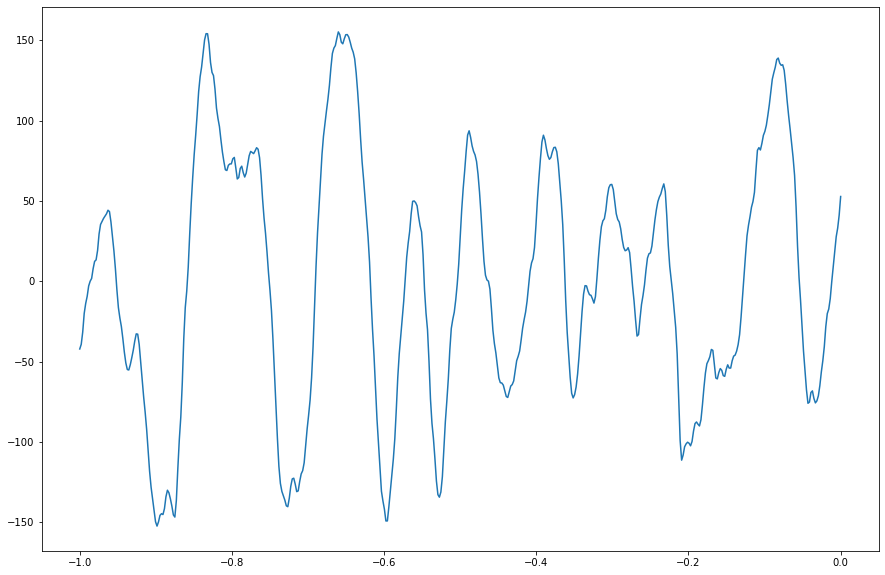

In [24]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[99,:, time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

In [25]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[103,:, time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

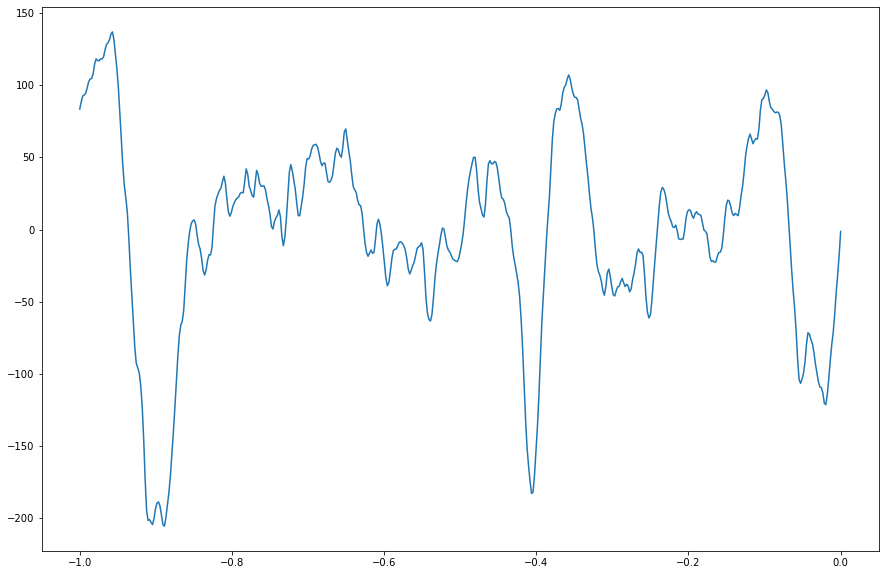

In [26]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[42,:, time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

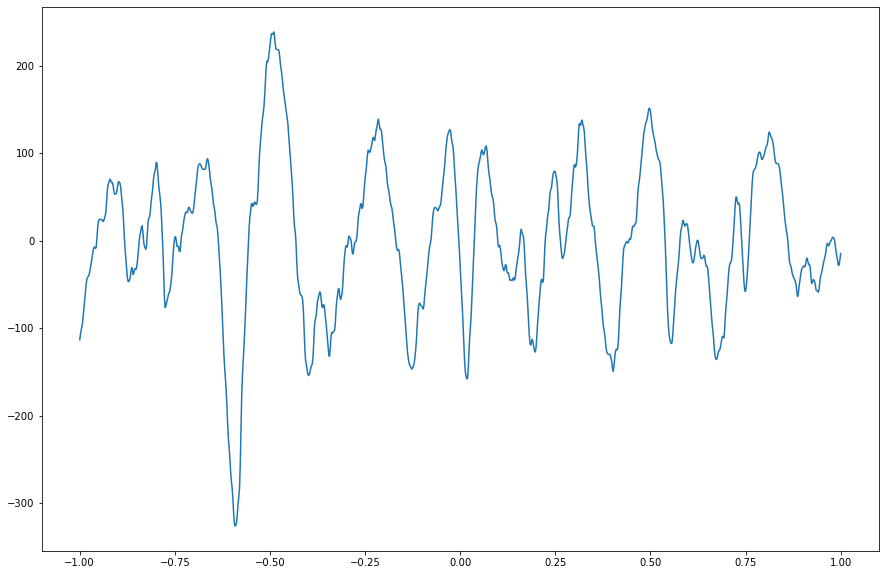

In [28]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 1) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[88,:, time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

# ALPHA

In [29]:
epochs_filtered = example_channel.copy().filter(l_freq=9, h_freq=150, fir_design='firwin')


Setting up band-pass filter from 9 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 751 samples (1.467 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


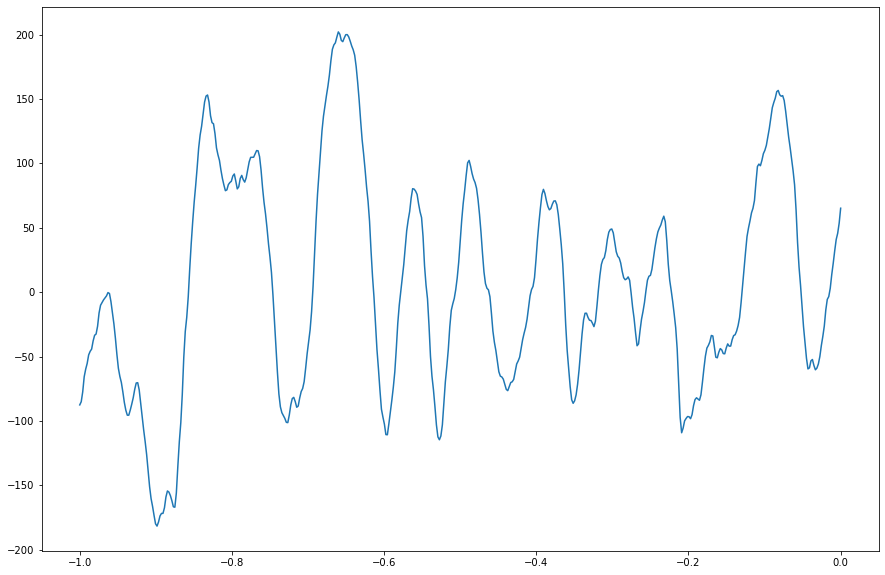

In [30]:
plt.rcParams['figure.figsize'] = [15, 10]

time_index = np.where((last_away_epochs.times <= 0) & (last_away_epochs.times >= -1))
time_series = np.squeeze(example_data[99,time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

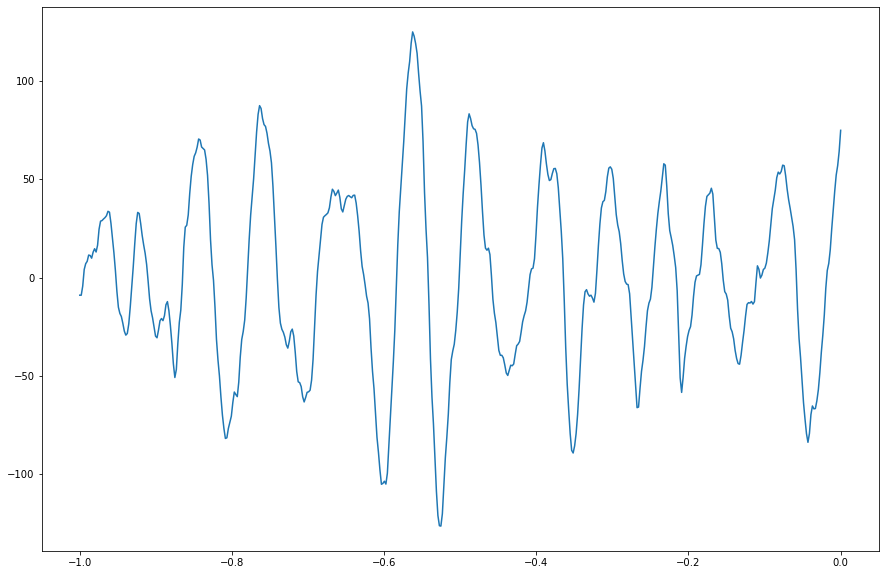

In [31]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[99,:, time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

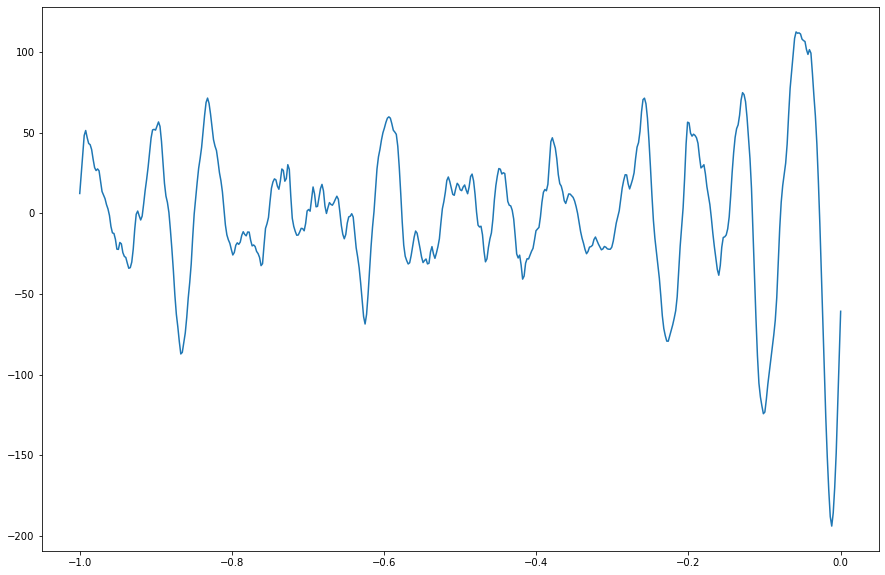

In [32]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[103,:, time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

In [33]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 0) & (epochs_filtered.times >= -1))
time_series = np.squeeze(filtered_data[42,:, time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

In [35]:
filtered_data = epochs_filtered.get_data()
time_index = np.where((epochs_filtered.times <= 1) & (epochs_filtered.times >= 0))
time_series = np.squeeze(filtered_data[88,:, time_index])

plt.plot(last_away_epochs.times[time_index],time_series)

Setting up band-pass filter from 3 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 845 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


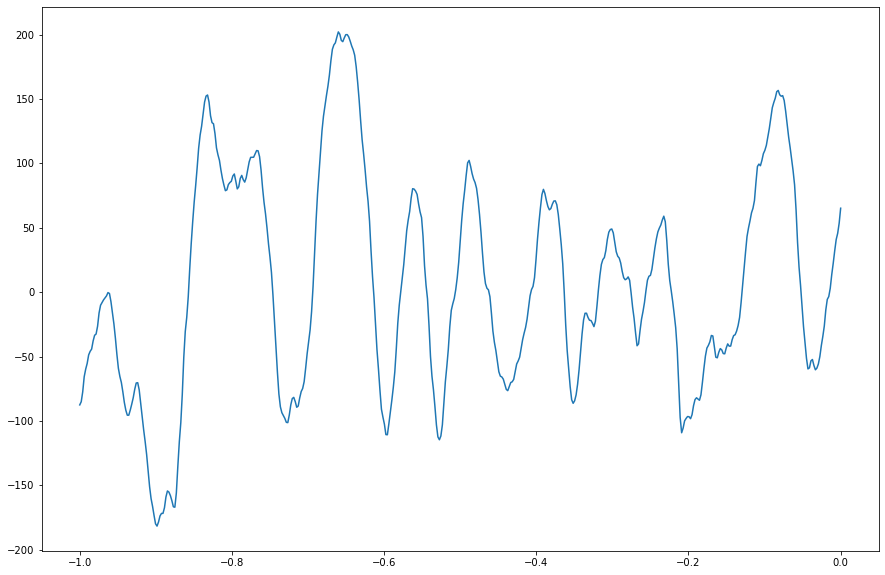

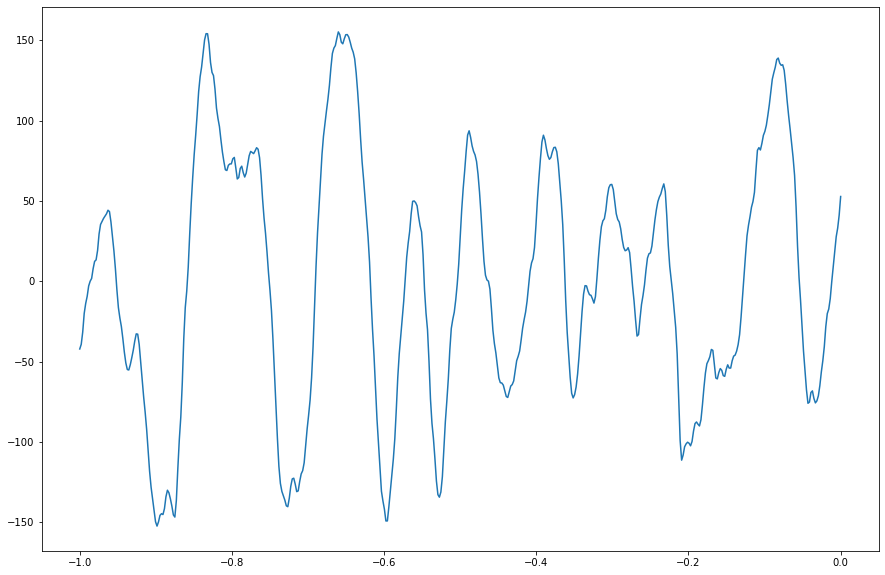

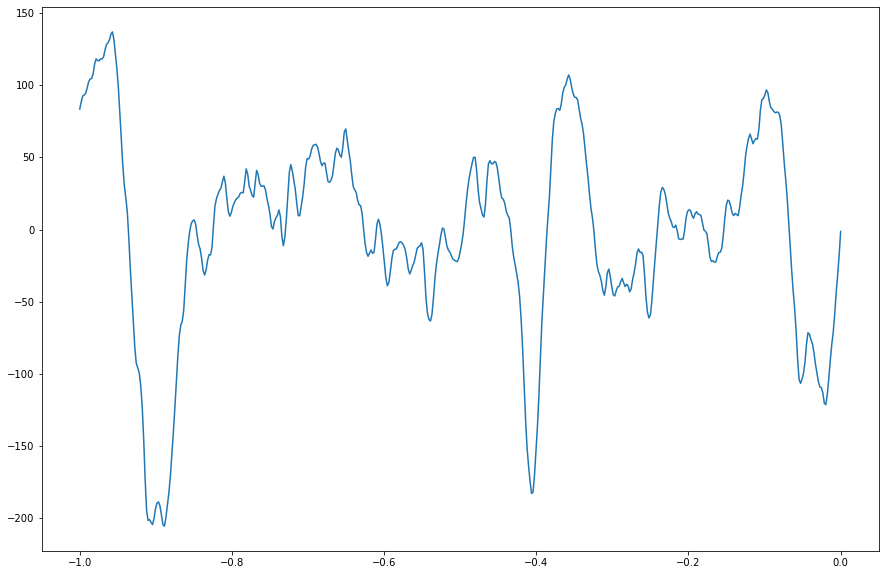

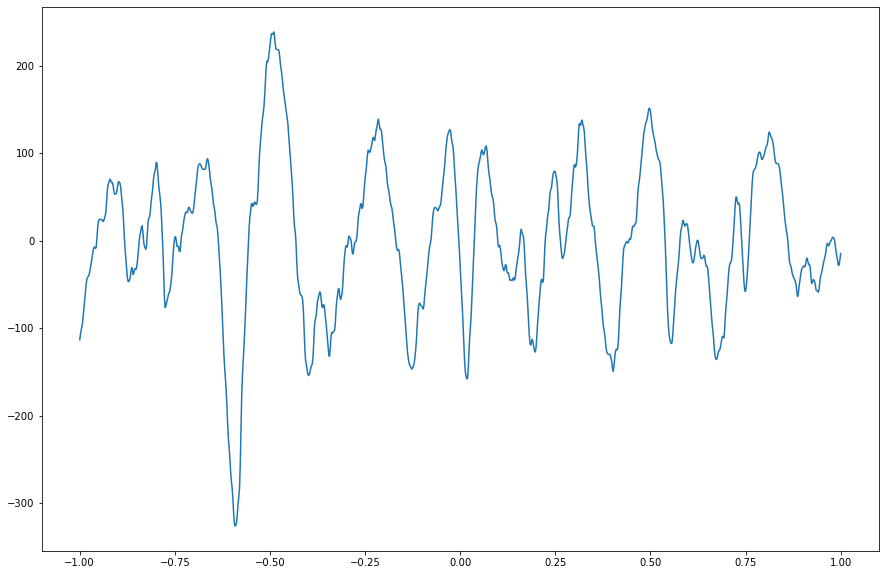